In [1]:
!pip install kora -q
from kora import drive
drive.link_nbs()

     |████████████████████████████████| 57 kB 1.9 MB/s 
     |████████████████████████████████| 60 kB 2.4 MB/s 
Mounted at /content/drive


In [2]:
import utils
from google.colab.patches import cv2_imshow

importing Jupyter notebook from /nbs/utils.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#import efficientnet.keras as efn
#from keras.applications.efficientnet import EfficientNetB0
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPool2D, Add, Activation
from tensorflow import keras
import numpy as np

In [4]:
IMG_SIZE = (224,224)
EPOCHS = 30
BATCH_SIZE = 32
NUM_CLASSES = 4


In [5]:
""" Load TVHI dataset """
#Load the dataset which has already been preprocessed, set needDirectories to False if SF_train, SF_test, and SF_validation dirs already exist
train_ds, test_ds, val_ds, train_labels, test_labels, validation_labels, class_names = utils.loadTVHI(img_size = IMG_SIZE, needDirectories=True)

#Path to pre-trained model
#SF_weights = "/content/drive/MyDrive/model_weights.h5"


--2022-04-19 19:48:40--  http://www.robots.ox.ac.uk/~alonso/data/tv_human_interactions_videos.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~alonso/data/tv_human_interactions_videos.tar.gz [following]
--2022-04-19 19:48:40--  https://www.robots.ox.ac.uk/~alonso/data/tv_human_interactions_videos.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163535078 (156M) [application/x-gzip]
Saving to: ‘tv_human_interactions_videos.tar.gz’

tv_human_interactio 100%[===================>] 155.96M  32.7MB/s    in 5.5s    

2022-04-19 19:48:46 (28.6 MB/s) - ‘tv_human_interactions_videos.tar.gz’ saved [163535078/163535078]

--2022-04-19 19:48:46--  http://www.robots.ox.ac.uk/~alonso/data/readme

In [6]:
""" One-hot encoding """

def onehot_encoding(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

#Apply one hot encoding to the different datasets
train_ds = train_ds.map(onehot_encoding, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(onehot_encoding, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(onehot_encoding)


tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
indexis:  [2]
(32, 224, 224, 3)
hug


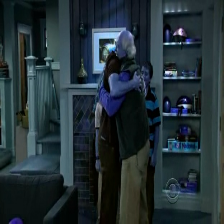

tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
indexis:  [2]
(32, 224, 224, 3)
hug


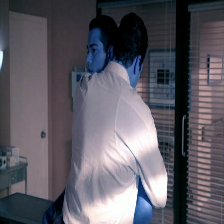

In [7]:
import matplotlib.pyplot as plt


for images, labels in train_ds.take(2):
  print(labels[0])
  index=[i for i, e in enumerate(labels[0]) if e == 1]
  print("indexis: ",index)
  print(images.shape)
  print(class_names[index[0]])
  cv2_imshow(images[0].numpy().astype("uint8"))

In [8]:
# x, y = next(iter(train_ds))

# print("x shape: ", x.shape)

# print("y shape: ", y.shape)




# x_0 = x

# y_0 = y

# print("x_0 shape: ", x_0.shape)

# print("y_0 shape: ", y_0.shape)




# num_of_images=16

# fig=plt.figure(figsize=(8,8))

# plt.title(f"one sample with {num_of_images} frames ; activity:{y_0}")

# subplot_num = int(np.ceil(np.sqrt(num_of_images)))

# for i in range(int(num_of_images)):

#   ax = fig.add_subplot(subplot_num, subplot_num, i+1)

#   #ax.imshow(output_image[0,:,:,i],interpolation='nearest' ) #to see the first filter

#   ax.imshow(x_0[i,:,::-1])

#   plt.xticks([])

#   plt.yticks([])

#   plt.tight_layout()

# plt.show()

In [9]:
#https://proceedings.neurips.cc/paper/2019/file/fd2c5e4680d9a01dba3aada5ece22270-Paper.pdf    - reference for using batch normalisation

In [10]:
class ResnetBlock(Model):  #Resnet18
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs
        
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        #inputs_2 = tf.keras.Input(shape=(224, 224, 3))
        #input_value = Input((224,224,3))
        #out = input_value
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [11]:
import keras
""" Build transfer learning model """


#AUTOTUNE = tf.data.AUTOTUNE
data_augmentation = Sequential([
        #keras.Input(shape=(None, 224, 224, 3)),
        layers.Rescaling(scale=1./255),
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomZoom(0.1),
        layers.RandomContrast(factor=0.1)

])

def build_tfl_model(num_classes):

    b_model = tf.keras.Sequential([
    # Add the preprocessing layers you created earlier.
      #keras.Input(shape=(None,224, 224, 3)),
      data_augmentation,
      ResNet18(40), #
    # Rest of your model.
    ])
 
    b_model.build(input_shape = (None,224,224,3))
    
    #Load old model and set the weights from there
    old_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ResNet18_1")
    b_model.set_weights(old_model.get_weights())#.expect_partial()
 
    # Freeze pretrained weights so no more training will happen
    b_model.trainable = False

    inputs = b_model.input
    b_output =  b_model.layers[-1].output


    # tvhi_output = layers.Dense(16)(b_output)
    # outputs = layers.Dense(4, activation='softmax')(tvhi_output)
    
    # Add new top layers that will be trained
    #x = GlobalAveragePooling2D(name="avg_pool")(b_output)
    x = BatchNormalization()(b_output)
    
  
    #Set dropout rate to 0.2 to adjust for overfitting as transfer learning is prone to overfitting
    dropout_rate = 0.2
    x = Dropout(dropout_rate, name="top_dropout")(x)
    outputs = Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    tvhi_model = keras.Model(inputs,outputs)

    #tvhi_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    #default learningrate of Adam is 0.001 so should be 1e-4 (1/10 * 0.001)
    tf_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    tvhi_model.compile(
        optimizer=tf_optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return tvhi_model


In [12]:
""" Train the model """
#Build the model
model = build_tfl_model(num_classes=NUM_CLASSES)
model.summary()

#Fit the model 
#history = model.fit(train_ds, epochs=50, validation_data=val_ds, verbose=2)

#Save weights and model as we need these for transfer learning 
#model.save_weights("TFL_weights.h5")
#model.save("TFL_model")


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_input (InputLaye  [(None, 224, 224, 3)]    0         
 r)                                                              
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 res_net18 (ResNet18)        (None, 40)                11211432  
                                                                 
 batch_normalization_20 (Bat  (None, 40)               160       
 chNormalization)                                  

In [13]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# checkpoint = ModelCheckpoint("TFL_Model_1", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1, save_format="tf")
# early = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')


In [13]:
history=model.fit(train_ds, epochs=20, validation_data=val_ds, verbose=1)

Epoch 1/20
3/3 [==============================] - 11s 3s/step - loss: 1.6633 - accuracy: 0.3294 - val_loss: 1.3733 - val_accuracy: 0.3333
Epoch 2/20
3/3 [==============================] - 7s 2s/step - loss: 1.3922 - accuracy: 0.3647 - val_loss: 1.3784 - val_accuracy: 0.3333
Epoch 3/20
3/3 [==============================] - 7s 2s/step - loss: 1.4565 - accuracy: 0.3529 - val_loss: 1.3786 - val_accuracy: 0.3333
Epoch 4/20
3/3 [==============================] - 7s 2s/step - loss: 1.3431 - accuracy: 0.3647 - val_loss: 1.3788 - val_accuracy: 0.4000
Epoch 5/20
3/3 [==============================] - 7s 2s/step - loss: 1.2810 - accuracy: 0.3882 - val_loss: 1.3783 - val_accuracy: 0.4667
Epoch 6/20
3/3 [==============================] - 8s 3s/step - loss: 1.3535 - accuracy: 0.3529 - val_loss: 1.3789 - val_accuracy: 0.4000
Epoch 7/20
3/3 [==============================] - 7s 2s/step - loss: 1.2148 - accuracy: 0.5176 - val_loss: 1.3792 - val_accuracy: 0.4000
Epoch 8/20
3/3 [========================

In [14]:
#Printing the val & training loss and accuracy for baseline model 
print(f"Baseline model training accuracy: {history.history['accuracy'][-1]} and validation accuracy: {history.history['val_accuracy'][-1]}")
print(f"Baseline model training loss: {history.history['loss'][-1]} and validation loss: {history.history['val_loss'][-1]}")

Baseline model training accuracy: 0.47058823704719543 and validation accuracy: 0.5333333611488342
Baseline model training loss: 1.1373999118804932 and validation loss: 1.384179949760437


In [15]:
model.save('/content/drive/MyDrive/Colab Notebooks/TFLModel_1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/TFLModel_1/assets


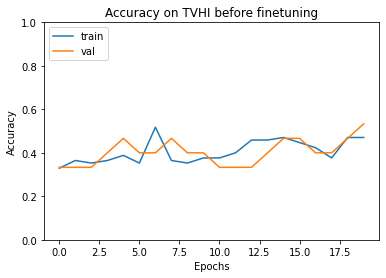

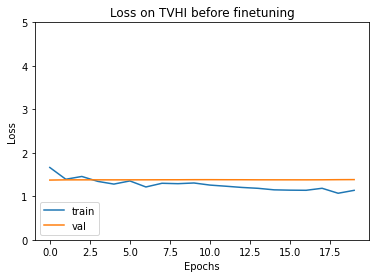

In [16]:
#Plot loss and accuracy before finetuning
utils.plotAccuracy("Accuracy on TVHI before finetuning", history.history['accuracy'], history.history['val_accuracy'])                   
utils.plotLoss("Loss on TVHI before finetuning", history.history['loss'], history.history['val_loss'])

In [17]:
## Evaluation

ModelLoss, ModelAccuracy = model.evaluate(test_ds)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

4/4 [==============================] - 7s 1s/step - loss: 1.3894 - accuracy: 0.2500
Model Loss is 1.3893957138061523
Model Accuracy is 0.25


In [18]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-50:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 10
history2 = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)

utils.plotAccuracy("Accuracy on TVHI after finetuning", history2.history['accuracy'], history2.history['val_accuracy'])
utils.plotLoss("Loss on TVHI after finetuning", history2.history['loss'], history2.history['val_loss'])


Epoch 1/10
3/3 - 28s - loss: 1.7285 - accuracy: 0.2941 - val_loss: 1.4177 - val_accuracy: 0.0667 - 28s/epoch - 9s/step
Epoch 2/10


KeyboardInterrupt: ignored